# Time Series Model - Power Consumption Forecast

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-demand-estimation/Electricity Consumption.csv


In [2]:
# Installing packages
!pip install pmdarima
!pip install prophet
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.7 MB/s eta 0:00:00


In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [4]:
# Loading dataset
df = pd.read_csv("/kaggle/input/electricity-demand-estimation/Electricity Consumption.csv")
df

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


In [5]:
# Viewing the first 5 data
df.head()

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107


In [6]:
# Viewing the last 5 data
df.tail()

,DATE,Electricty_Consumption_in_TW
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765
560,9/1/2019,109.7190


In [7]:
# Info data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [8]:
# Data types
df.dtypes

DATE                             object
Electricty_Consumption_in_TW    float64
dtype: object

In [9]:
# Viewing rows and columns
df.shape

(561, 2)

In [10]:
# Check and handle missing values
df = df.dropna()

In [11]:
# Transforming "Date" column into datetime
df['DATE'] = pd.to_datetime(df['DATE'])

In [12]:
# Transform "DATA" column into index
df.set_index('DATE', inplace=True)
df

,Electricty_Consumption_in_TW
DATE,
1973-01-01,35.9728
1973-02-01,36.1334
1973-03-01,35.0625
1973-04-01,33.8416
1973-05-01,33.5107
...,...
2019-05-01,97.5860
2019-06-01,110.8580
2019-07-01,122.1014


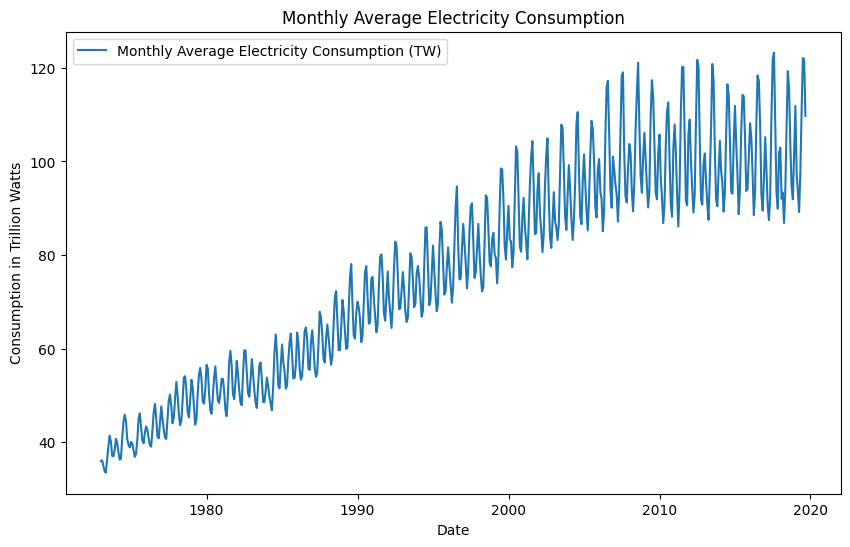

In [13]:
# View the data
plt.figure(figsize=(10, 6))
plt.plot(df, label='Monthly Average Electricity Consumption (TW)')
plt.title('Monthly Average Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Consumption in Trillion Watts')
plt.legend()
plt.show()

# Monthly Average Electricity Consumption

The graph illustrates the monthly average electricity consumption over a span of several decades, from the 1970s to around 2020. Here are the key components and insights from the graph:

### Key Components:

1. **X-axis (Date)**:
   - The x-axis represents the timeline from the 1970s to around 2020.
   - Each point on the x-axis corresponds to a month within this time frame.

2. **Y-axis (Consumption in Trillion Watts)**:
   - The y-axis measures the monthly average electricity consumption in trillion watts (TW).
   - The values range from approximately 40 TW to over 120 TW.

3. **Line Plot**:
   - The blue line represents the monthly average electricity consumption.
   - The line shows the trend and seasonal patterns in electricity consumption over time.

### Observations:

1. **Overall Trend**:
   - There is a clear upward trend in electricity consumption from the 1970s to 2020.
   - This indicates a general increase in electricity usage over the decades, likely due to population growth, industrialization, and increased use of electronic devices.

2. **Seasonal Variation**:
   - The graph exhibits regular fluctuations within each year, indicating seasonal variation in electricity consumption.
   - Peaks and troughs can be observed, which may correspond to higher consumption during winter and summer months due to heating and cooling needs.

3. **Significant Events**:
   - There are some noticeable spikes and drops that deviate from the overall trend.
   - These could be due to significant events such as economic crises, policy changes, or extraordinary weather conditions affecting electricity consumption.

### Summary:

This graph provides a comprehensive view of the historical patterns in monthly average electricity consumption. It highlights the overall increase in consumption over the years, as well as the consistent seasonal variations. Understanding these patterns is crucial for energy planning, policy-making, and forecasting future electricity demand.


# ADF Test (Augmented Dickey-Fuller)

The ADF test is a statistical test used to check for the presence of a unit root in a time series, i.e., to determine if the time series is stationary or not.

## Stationarity
A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, are constant over time. Testing for stationarity is crucial in time series models like ARIMA, where the assumption of stationarity is fundamental for proper modeling.

## Hypotheses
- **Null Hypothesis (H0)**: The time series has a unit root (is not stationary).
- **Alternative Hypothesis (H1)**: The time series does not have a unit root (is stationary).

## Test Components
- **Test Statistic (ADF Statistic)**: Statistic calculated from the data.
- **Critical Values**: Reference values for different significance levels (1%, 5%, 10%). If the test statistic is less than the critical value, we reject the null hypothesis.
- **P-Value**: Probability of obtaining a test statistic equal to or more extreme, assuming the null hypothesis is true. If the p-value is less than a chosen significance level (e.g., 0.05), we reject the null hypothesis.

## ADF Model
It can include trend (deterministic) and/or drift (stochastic trend) terms to accommodate different types of time series.

The ADF test is widely used in econometrics and time series analysis to ensure the series is suitable for modeling or to determine the need for transformations, such as differencing, to achieve stationarity.

## Example in Python

```python
import pandas as pd
from statsmodels.tsa.stattools import adfuller

# Suppose we have a time series 'data'
result = adfuller(data)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'{key}: {value}')


In [14]:
# Check stationarity with the ADF test
result = adfuller(df['Electricty_Consumption_in_TW'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

for key, value in result[4].items():
    print('Critical Values:')
    print(f' {key}, {value}')

ADF Statistic: -1.7405933729832495
p-value: 0.4103281604468654
Critical Values:
 1%, -3.442405720052601
Critical Values:
 5%, -2.866857804790472
Critical Values:
 10%, -2.5696022094099824


# Training and testing

In [15]:
# Split data into training and testing
train = df[df.index < '2010-01-01']
test = df[df.index >= '2010-01-01']

In [16]:
# Viewing training and testing
train.shape

(444, 1)

In [17]:
# Viewing test data
test.shape

(117, 1)

# AutoARIMA

AutoARIMA is an automated tool for finding the best ARIMA (AutoRegressive Integrated Moving Average) model for a time series dataset. The ARIMA model is a statistical method used to analyze and forecast time series data, considering three main components:

1. **AR (AutoRegressive)**: The autoregressive part of the model that uses the dependency between an observation and a number of lagged observations (lags) from previous time periods.
2. **I (Integrated)**: The integrated part of the model that uses the differencing of observations to make the time series stationary.
3. **MA (Moving Average)**: The moving average part that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

AutoARIMA automates the process of identifying the best parameters (p, d, q) for the ARIMA model. These parameters are:

- **p**: Order of the autoregressive component.
- **d**: Order of differencing needed to make the series stationary.
- **q**: Order of the moving average component.

## Features of AutoARIMA

1. **Automatic Parameter Selection**: Automatically finds the best values for p, d, and q by testing various combinations and selecting the one that minimizes a specified information criterion, such as AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion).
2. **Stationarity Diagnosis**: Detects if the series is stationary and, if not, applies the necessary differencing.
3. **Seasonality Check**: Can detect and model seasonal components.
4. **Model Testing**: Evaluates multiple ARIMA models and selects the best performing one.

## Advantages

- **Ease of Use**: Automates the parameter selection process, making it simpler for non-experts.
- **Efficiency**: Quickly finds the best ARIMA model without extensive manual testing.
- **Flexibility**: Can be used for various types of time series, including seasonal and non-seasonal series.

## Use Cases

- Product demand forecasting.
- Energy production forecasting.
- Market trend analysis.

In [18]:
# Apply AutoARIMA to identify the best parameters
stepwise_model = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_p=3,
                            max_q=3,
                            m=12,
                            start_P=0,
                            seasonal=True,
                            d=1,
                            D=1,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Summary model
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1645.392, Time=1.04 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1867.815, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1777.693, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1695.731, Time=0.51 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1647.167, Time=1.14 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1647.035, Time=1.66 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=1649.153, Time=2.96 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1705.955, Time=0.55 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1643.263, Time=1.66 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=inf, Time=0.56 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1645.013, Time=1.60 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=1644.864, Time=2.62 sec
 ARIMA(2,1,1)(1,1,0)[12]          

# ARIMA Model

The ARIMA (AutoRegressive Integrated Moving Average) model is a widely used statistical method for analyzing and forecasting time series data. It combines three components: autoregression (AR), differencing to achieve stationarity (I), and moving average (MA).

## Components of ARIMA

1. **AR (AutoRegressive)**: This component uses the dependency between an observation and a number of lagged observations (lags). The order of the autoregressive part is denoted by `p`.

2. **I (Integrated)**: This component involves differencing the observations (subtracting the previous observation from the current observation) to make the time series stationary. The number of differencing required is denoted by `d`.

3. **MA (Moving Average)**: This component uses the dependency between an observation and a residual error from a moving average model applied to lagged observations. The order of the moving average part is denoted by `q`.

## ARIMA(p, d, q)

The ARIMA model is typically denoted as ARIMA(p, d, q), where:
- `p` is the number of lag observations included in the model (autoregressive part).
- `d` is the number of times that the raw observations are differenced (integrated part).
- `q` is the size of the moving average window (moving average part).

## Model Formulation

### AR Component
The autoregressive component can be represented as:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t
$$

where:

- \( y_t \) is the value at time \( t \)
- \( c \) is a constant
- \(\phi_1, \phi_2, \ldots, \phi_p \) are the parameters of the autoregressive model
- \( \epsilon_t \) is white noise


### I Component
The integrated part involves differencing the time series. If \( d = 1 \), the differenced series \( y'_t \) is:

$$
y'_t = y_t - y_{t-1}
$$

### MA Component
The moving average component can be represented as:

$$
y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}
$$

where:
- \( \epsilon_t \) is white noise
- \( \theta_1, \theta_2, \ldots, \theta_q \) are the parameters of the moving average model

### Combined ARIMA Model
The combined ARIMA model is:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \cdots + \theta_q \epsilon_{t-q}
$$

## Steps to Build an ARIMA Model

1. **Identification**: Determine the values of `p`, `d`, and `q` by analyzing the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots, and by ensuring the series is stationary.
   
2. **Estimation**: Estimate the parameters of the ARIMA model using methods like Maximum Likelihood Estimation (MLE).

3. **Diagnostic Checking**: Check the residuals of the fitted model to ensure they resemble white noise. This involves analyzing the residuals' ACF, PACF, and performing statistical tests like the Ljung-Box test.

4. **Forecasting**: Use the fitted ARIMA model to make forecasts.

In [19]:
# Train the ARIMA model with the identified parameters

# ARIMA model
model = ARIMA(train, order=stepwise_model.order, seasonal_order=stepwise_model.seasonal_order)

# Model training
model_fit = model.fit()

# Summary model
print(model_fit.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:       Electricty_Consumption_in_TW   No. Observations:                  444
Model:             ARIMA(3, 1, 3)x(0, 1, [1], 12)   Log Likelihood                -810.938
Date:                            Tue, 09 Jul 2024   AIC                           1637.875
Time:                                    04:23:48   BIC                           1670.404
Sample:                                01-01-1973   HQIC                          1650.719
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8049      0.189     -4.264      0.000      -1.175      -0.435
ar.L2          0.0607      0.086   

In [20]:
# forecast model
forecast = model_fit.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)
forecast

DATE
2010-01-01    105.253645
2010-02-01    100.963293
2010-03-01     96.235300
2010-04-01     90.935631
2010-05-01     96.101182
                 ...    
2019-05-01    107.137116
2019-06-01    120.373419
2019-07-01    129.222547
2019-08-01    129.890327
2019-09-01    117.831597
Name: predicted_mean, Length: 117, dtype: float64

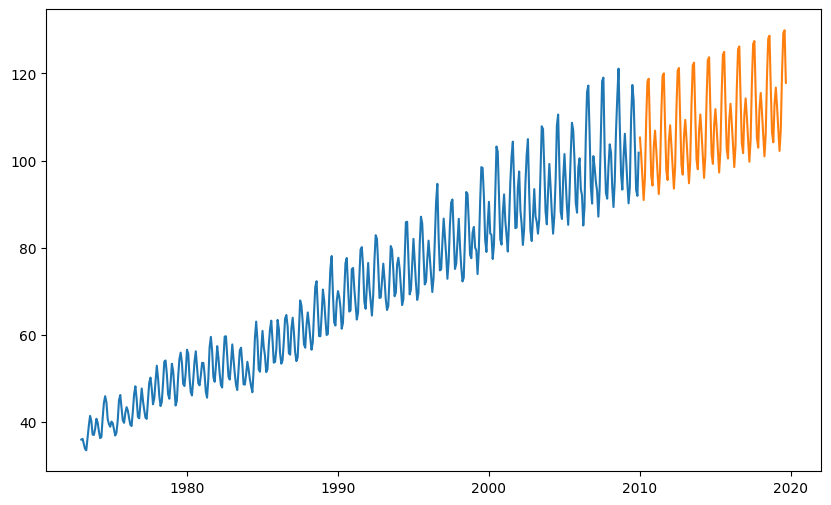

In [21]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(forecast, label='Forecast')
plt.show()

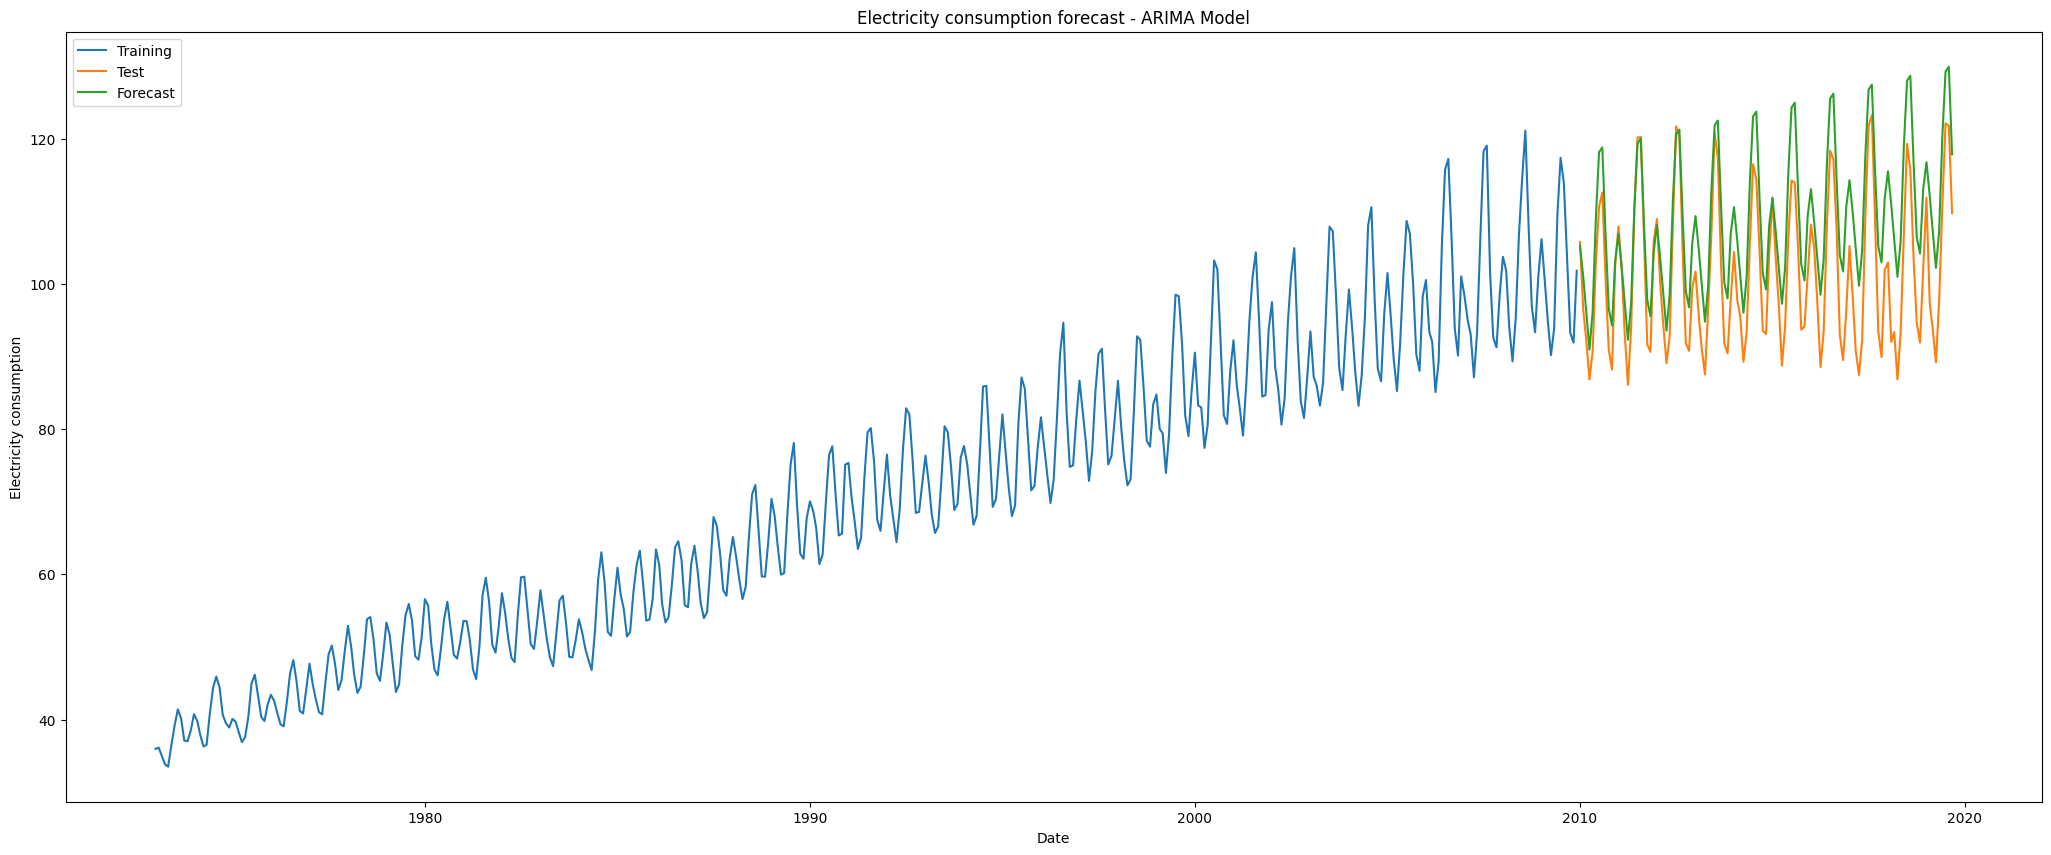

In [22]:
# Plot predictions
plt.figure(figsize=(25.5, 10))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast')
plt.legend(loc='upper left')
plt.title('Electricity consumption forecast - ARIMA Model')
plt.ylabel('Electricity consumption')
plt.xlabel('Date')
plt.show()

# Electricity Consumption Forecast - ARIMA Model

The graph illustrates the actual and forecasted monthly average electricity consumption using an ARIMA model. Here are the key components and insights from the graph:

### Key Components:

1. **X-axis (Date)**:
   - The x-axis represents the timeline from the 1970s to around 2020.
   - Each point on the x-axis corresponds to a month within this time frame.

2. **Y-axis (Electricity Consumption)**:
   - The y-axis measures the monthly average electricity consumption in trillion watts (TW).
   - The values range from approximately 40 TW to over 120 TW.

3. **Lines and Colors**:
   - **Blue Line (Training)**: Represents the historical data used to train the ARIMA model. This data spans from the 1970s to just before the test period.
   - **Orange Line (Test)**: Represents the actual electricity consumption data that was not used in training and is used to evaluate the model's performance. This data spans from around 2010 to 2020.
   - **Green Line (Forecast)**: Represents the forecasted electricity consumption by the ARIMA model for the test period.

### Observations:

1. **Training Data (Blue Line)**:
   - The training data shows an increasing trend in electricity consumption from the 1970s to around 2010, with noticeable seasonal fluctuations.

2. **Test Data (Orange Line)**:
   - The test data continues to show the seasonal pattern and increasing trend observed in the training data, providing a basis for evaluating the model's performance.

3. **Forecast Data (Green Line)**:
   - The forecasted data by the ARIMA model closely follows the test data, indicating that the model has captured the underlying trend and seasonality of the electricity consumption effectively.
   - The forecast shows both short-term seasonal fluctuations and long-term trends.

### Summary:

This graph demonstrates the performance of an ARIMA model in forecasting monthly average electricity consumption. The model was trained on historical data (blue line) and then used to predict future consumption (green line), which is compared against the actual observed values (orange line). The close alignment of the forecasted values with the test data suggests that the ARIMA model is effective in capturing the patterns in the data, making it a useful tool for forecasting electricity consumption.

In [23]:
# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast) * 100

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

RMSE: 8.224808433064995
MAPE: 7.3661831195510885%


# SARIMA Model

The SARIMA (Seasonal Autoregressive Integrated Moving Average) model is an extension of the ARIMA model that includes seasonal components. It is represented by the notation \((p, d, q) \times (P, D, Q)_s\), where:

- \( p \): order of the autoregressive (AR) component
- \( d \): degree of differencing to make the series stationary
- \( q \): order of the moving average (MA) component
- \( P \): order of the seasonal autoregressive (SAR) component
- \( D \): degree of seasonal differencing
- \( Q \): order of the seasonal moving average (SMA) component
- \( s \): seasonality period

## Mathematical Formulas of SARIMA

### 1. ARIMA Model \((p, d, q)\):

$$ \phi(B)^p (1 - B)^d Y_t = \theta(B)^q \epsilon_t $$

Onde:

$$\phi(B)$$ is the autoregressive polynomial of order \( p \)

$$(1 - B)^d$$ is the differentiation operator of order \( d \)

$$\theta(B)$$ is the moving average polynomial of order \( q \)

$$Y_t$$ is the time series

$$\epsilon_t$$ is the error term (white noise)

### 2. Seasonal Component:

$$ \Phi(B^s)^P (1 - B^s)^D Y_t = \Theta(B^s)^Q \epsilon_t $$

Onde:
$$\Phi(B^s)$$ is the seasonal autoregressive polynomial of order \( P \)$$

$$(1 - B^s)^D$$ is the seasonal differentiation operator of order \( D \)$$

$$\Theta(B^s)$$ is the seasonal moving average polynomial of order \( Q \)$$

### 3. Combined SARIMA Model:

$$ \phi(B) \Phi(B^s) (1 - B)^d (1 - B^s)^D Y_t = \theta(B) \Theta(B^s) \epsilon_t $$

## Polynomial Details

### Autoregressive (AR) Polynomial

$$ \phi(B) = 1 - \phi_1 B - \phi_2 B^2 - \cdots - \phi_p B^p $$

### Moving Average (MA) Polynomial

$$ \theta(B) = 1 + \theta_1 B + \theta_2 B^2 + \cdots + \theta_q B^q $$

### Seasonal Autoregressive (SAR) Polynomial

$$ \Phi(B^s) = 1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps} $$

### Seasonal Moving Average (SMA) Polynomial

$$ \Theta(B^s) = 1 + \Theta_1 B^s + \Theta_2 B^{2s} + \cdots + \Theta_Q B^{Qs} $$

## Explanation of Terms

$$B$$: lag operator, where \( B Y_t = Y_{t-1} \)

$$\phi_i$$: coefficients of the AR polynomial

$$\theta_i$$: coefficients of the MA polynomial

$$\Phi_i$$: SAR polynomial coefficients

$$\Theta_i$$: coefficients of the SMA polynomial

These formulas describe the relationship between past and present values ​​of the time series, incorporating both the autoregressive and moving average structures, as well as the seasonal components.

In [24]:
# Importing library
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Creating AutoARIMA model
stepwise_model = auto_arima(train, 
                            start_p=1, 
                            start_q=1,
                            max_p=3, 
                            max_q=3, 
                            m=30,
                            start_P=0, 
                            seasonal=True,
                            d=1, 
                            D=1, 
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Viewing summary
print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[30]             : AIC=inf, Time=2.97 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=2390.027, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=inf, Time=1.58 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=2.49 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=inf, Time=1.50 sec
 ARIMA(0,1,0)(0,1,1)[30]             : AIC=2113.209, Time=1.72 sec
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=1877.295, Time=1.69 sec
 ARIMA(0,1,0)(2,1,1)[30]             : AIC=1876.922, Time=12.72 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=inf, Time=3.86 sec
 ARIMA(0,1,0)(2,1,2)[30]             : AIC=1871.824, Time=16.66 sec
 ARIMA(0,1,0)(1,1,2)[30]             : AIC=1871.815, Time=9.68 sec
 ARIMA(0,1,0)(0,1,2)[30]             : AIC=inf, Time=6.16 sec
 ARIMA(1,1,0)(1,1,2)[30]             : AIC=1873.809, Time=10.24 sec
 ARIMA(0,1,1)(1,1,2)[30]             : AIC=1873.805, Time=16.26 sec
 ARIMA(1,1,1)(1,1,2)[30]             : AIC=18

In [25]:
# Creating SARIMA model
model = SARIMAX(train, order=stepwise_model.order, seasonal_order=stepwise_model.seasonal_order)

# Model training
model_fit = model.fit(disp=False)

# model summary
print(model_fit.summary())

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary star

                                     SARIMAX Results                                      
Dep. Variable:       Electricty_Consumption_in_TW   No. Observations:                  444
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 30)   Log Likelihood                -888.485
Date:                            Tue, 09 Jul 2024   AIC                           1794.970
Time:                                    04:41:58   BIC                           1831.181
Sample:                                01-01-1973   HQIC                          1809.292
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5384      0.047     32.406      0.000       1.445       1.631
ar.L2         -0.7773      0.037   

In [26]:
# Model forecast
forecast = model_fit.get_forecast(steps=len(test))
forecast_index = forecast.predicted_mean.index
forecast_values = forecast.predicted_mean.values

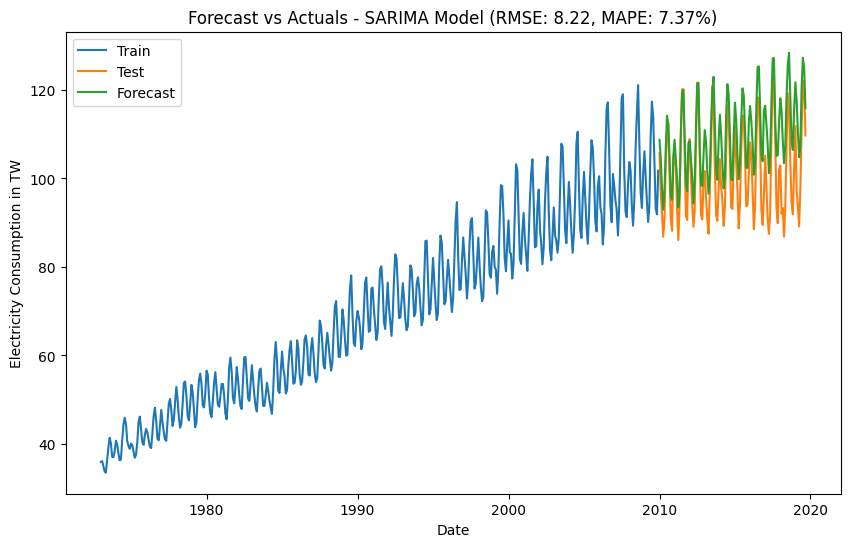

In [27]:
# Plot model
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast_index, forecast_values, label='Forecast')
plt.legend(loc='upper left')
plt.title(f'Forecast vs Actuals - SARIMA Model (RMSE: {rmse:.2f}, MAPE: {mape:.2f}%)')
plt.ylabel('Electricity Consumption in TW')
plt.xlabel('Date')
plt.show()

In [28]:
# Calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test, forecast_values))
mape = mean_absolute_percentage_error(test, forecast_values) * 100

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

RMSE: 9.337470322140522
MAPE: 8.299954934834712%


# Regression Model with GPU

## Model 3 - XGBoost LightGBM Regression

**Model 1 - XGBoost**

# XGBoost Model

XGBoost (Extreme Gradient Boosting) is an optimized implementation of gradient boosting decision trees designed to be highly efficient, flexible, and portable. It is one of the most popular machine learning libraries due to its high performance in data science competitions and real-world applications. Here are some of the main concepts and features of XGBoost:

### Key Features:

1. **Gradient Boosting**:
   - XGBoost is based on the gradient boosting technique, where new models are added sequentially to correct the errors of the previous models.
   - Each new model is trained to predict the residuals (errors) of the previous models, and the results are summed to make the final prediction.

2. **Decision Trees**:
   - It uses decision trees as its base models, specifically regression decision trees.
   - Trees are added one at a time, and the weights of the trees are adjusted to minimize the loss function.

3. **Regularization**:
   - XGBoost includes regularization terms (L1 and L2) to prevent overfitting, which helps improve the model's generalization.
   - Regularization penalizes model complexity, reducing the likelihood of overfitting the training data.

4. **Parallel Computing**:
   - Implemented to take advantage of parallel computing, significantly speeding up training on large datasets.
   - Supports parallel tree construction and column block splitting.

5. **Handling Missing Data**:
   - XGBoost has built-in strategies to handle missing data during training and prediction.

6. **Customization**:
   - Allows customization of loss functions and evaluation metrics, making it very flexible for different types of machine learning problems.

### Common Applications:

1. **Classification**:
   - Problems where the goal is to categorize data into different classes, such as spam detection, medical diagnosis, etc.
   
2. **Regression**:
   - Problems where the goal is to predict continuous values, such as price prediction, time series analysis, etc.

3. **Ranking**:
   - Ranking problems, such as recommendation systems, where items need to be ranked based on relevance.

### Advantages:

- **High Performance**: XGBoost is known for its excellent performance and accuracy in machine learning competitions.
- **Speed**: Efficient implementation allows for fast training and prediction.
- **Flexibility**: Supports various loss functions and allows customization.

In [29]:
# Preprocessing transforming by dividing the columns
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek
df['weekofyear'] = df.index.isocalendar().week.astype(int)

In [30]:
# Features model
X = df[['year', 'month', 'day', 'dayofweek', 'weekofyear']]
y = df['Electricty_Consumption_in_TW']

In [31]:
# Viewing rows and columns x
X.shape

(561, 5)

In [32]:
# Viewing rows and columns y
y.shape

(561,)

# Model training

In [33]:
# Training and testing division
# Importing library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [34]:
# Viewing rows and columns X_train
X_train.shape

(448, 5)

In [35]:
# Viewing rows and columns y_train
y_train.shape

(448,)

In [36]:
# Importing libraries
import xgboost as xgb

# Creating linear regression model
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         learning_rate=0.01,
                         tree_method='gpu_hist',
                         predictor='gpu_predictor',
                         max_depth=100,
                         subsample=0.8,
                         colsample_bytree=0.8)

# Model training
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)],early_stopping_rounds=50,verbose=True)

/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:42:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:42:00] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:20.42038	validation_1-rmse:32.59844
[1]	validation_0-rmse:20.23323	validation_1-rmse:32.32844
[2]	validation_0-rmse:20.04995	validation_1-rmse:32.06963
[3]	validation_0-rmse:19.86556	validation_1-rmse:31.79251
[4]	validation_0-rmse:19.68351	validation_1-rmse:31.52713
[5]	validation_0-rmse:19.50416	validation_1-rmse:31.25128
[6]	validation_0-rmse:19.48853	validation_1-rmse:31.24628
[7]	validation_0-rmse:19.30894	validation_1-rmse:30.99929
[8]	validation_0-rmse:19.13108	validation_1-rmse:30.75459
[9]	validation_0-rmse:18.95647	validation_1-rmse:30.51497
[10]	validation_0-rmse:18.78330	validation_1-rmse:30.25728
[11]	validation_0-rmse:18.61192	validation_1-rmse:30.02487
[12]	validation_0-rmse:18.43941	validation_1-rmse:29.78194
[13]	validation_0-rmse:18.26988	validation_1-rmse:29.53250
[14]	validation_0-rmse:18.25534	validation_1-rmse:29.52067
[15]	validation_0-rmse:18.23913	validation_1-rmse:29.50827
[16]	validation_0-rmse:18.07371	validation_1-rmse:29.25220
[17]	va

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

In [37]:
# Model forecast
y_pred = model.predict(X_test)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:42:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [04:42:05] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


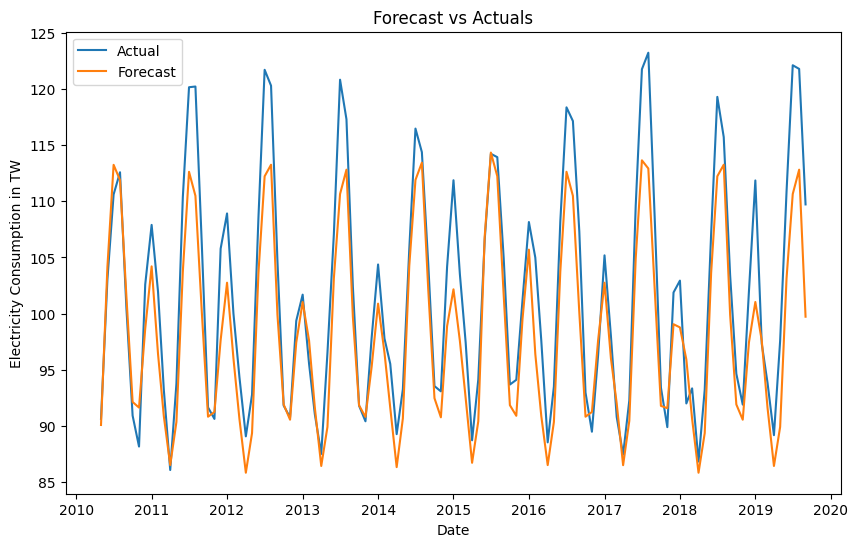

In [38]:
# prediction plot
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='upper left')
plt.title(f'Forecast vs Actuals')
plt.ylabel('Electricity Consumption in TW')
plt.xlabel('Date')
plt.show()

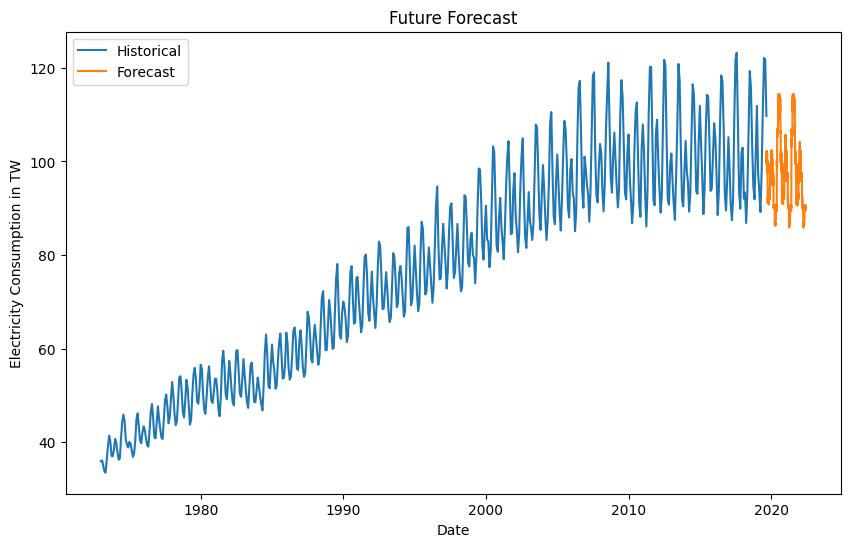

In [39]:
def create_future_dataframe(df, periods):
    last_date = df.index[-1]
    future_dates = pd.date_range(last_date, periods=periods, freq='D')[1:]
    future_df = pd.DataFrame(index=future_dates)
    future_df['year'] = future_df.index.year
    future_df['month'] = future_df.index.month
    future_df['day'] = future_df.index.day
    future_df['dayofweek'] = future_df.index.dayofweek
    future_df['weekofyear'] = future_df.index.isocalendar().week.astype(int)
    return future_df

# Create a future dataframe for 1000 days
future_df = create_future_dataframe(df, periods=1000)

# Use the model to predict electricity consumption over the next 1000 days
future_df['Electricty_Consumption_in_TW'] = model.predict(future_df)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Electricty_Consumption_in_TW'], label='Historical')
plt.plot(future_df.index, future_df['Electricty_Consumption_in_TW'], label='Forecast')
plt.legend(loc='upper left')
plt.title('Future Forecast')
plt.ylabel('Electricity Consumption in TW')
plt.xlabel('Date')
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Calculate RMSE, MAPE and R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')
print(f'R2: {r2}')

RMSE: 4.681216436045022
MAPE: 3.543466085188308%
R2: 0.7859181941586535


# LightGBM 2 - Model

LightGBM (Light Gradient Boosting Machine) is a high-performance, distributed gradient boosting framework based on decision tree algorithms. It is designed to be highly efficient and scalable, making it particularly well-suited for large datasets and high-dimensional data. Here are some of the main concepts and features of LightGBM:

### Key Features:

1. **Gradient Boosting Framework**:
   - LightGBM is based on the gradient boosting framework, where new models are added sequentially to correct the errors of the previous models.
   - Each new model is trained to predict the residuals (errors) of the previous models, and the results are combined to make the final prediction.

2. **Decision Trees**:
   - It uses decision trees as its base models, specifically leaf-wise (best-first) decision trees.
   - Unlike level-wise growth used in other implementations, LightGBM grows trees leaf-wise, choosing the leaf with the maximum loss to grow, which can lead to deeper trees and potentially better accuracy.

3. **Histogram-based Algorithms**:
   - LightGBM uses histogram-based algorithms for faster computation, reducing the number of data points evaluated at each split.
   - This approach significantly speeds up training by discretizing continuous features into discrete bins.

4. **Efficient Handling of Large Datasets**:
   - Designed to handle large datasets efficiently, both in terms of memory usage and computation speed.
   - Supports out-of-core computation, allowing it to process data that does not fit into memory by using disk-based storage.

5. **Support for Sparse Features**:
   - Efficiently handles sparse data, common in high-dimensional datasets, by skipping zero entries and reducing computation overhead.

6. **Parallel and Distributed Learning**:
   - Supports parallel learning, which can speed up training by distributing the workload across multiple processors or machines.
   - Scales well with the number of data points and features.

7. **Regularization**:
   - Includes L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting and improve model generalization.
   
8. **Customization**:
   - Allows customization of loss functions and evaluation metrics, providing flexibility for different types of machine learning problems.

### Common Applications:

1. **Classification**:
   - Problems where the goal is to categorize data into different classes, such as fraud detection, customer segmentation, etc.
   
2. **Regression**:
   - Problems where the goal is to predict continuous values, such as house price prediction, sales forecasting, etc.

3. **Ranking**:
   - Ranking problems, such as information retrieval and recommendation systems, where items need to be ordered based on relevance.

### Advantages:

- **High Performance**: LightGBM is known for its speed and efficiency, especially with large datasets.
- **Scalability**: Scales well with large datasets and high-dimensional data.
- **Flexibility**: Supports various loss functions and allows extensive customization.

In [41]:
# Assuming that the data is in a CSV file loading different dataset to solve the problem with data
data = pd.read_csv('/kaggle/input/electricity-demand-estimation/Electricity Consumption.csv')

In [42]:
# Transforming DATE variable into datetime
data['DATE'] = pd.to_datetime(data['DATE'])

In [43]:
# Transforming DATE into index
data.set_index('DATE', inplace=True)

In [44]:
# Create features for the model
data['year'] = df.index.year
data['month'] = df.index.month
data['day'] = df.index.day
data['dayofweek'] = df.index.dayofweek
data['weekofyear'] = df.index.isocalendar().week.astype(int)

# Viewing
data.head()

,Electricty_Consumption_in_TW,year,month,day,dayofweek,weekofyear
DATE,,,,,,
1973-01-01,35.9728,1973,1,1,0,1
1973-02-01,36.1334,1973,2,1,3,5
1973-03-01,35.0625,1973,3,1,3,9
1973-04-01,33.8416,1973,4,1,6,13
1973-05-01,33.5107,1973,5,1,1,18


In [45]:
# Training and testing division for LinghtGBM model
X = data[['year', 'month', 'day', 'dayofweek', 'weekofyear']]
y = data['Electricty_Consumption_in_TW']

In [46]:
# Importing library
import lightgbm as lgb

# Splitting into training and testing for model
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Model parameters
params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': ['rmse', 'mape'],
          'device': 'gpu',
          'gpu_platform_id': 0,
          'gpu_device_id': 0,
          'learning_rate': 0.01,
          'num_leaves': 31,
          'max_depth': 10,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_estimators': 1000}

# Model training
model = lgb.train(params, 
                  train_data, 
                  valid_sets=[test_data], 
                  num_boost_round=1000)

/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 82
[LightGBM] [Info] Number of data points in the train set: 448, number of used features: 4
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 4 dense feature groups (0.00 MB) transferred to GPU in 0.000288 secs. 0 sparse feature groups
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 70.383497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [47]:
# Model forecast
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

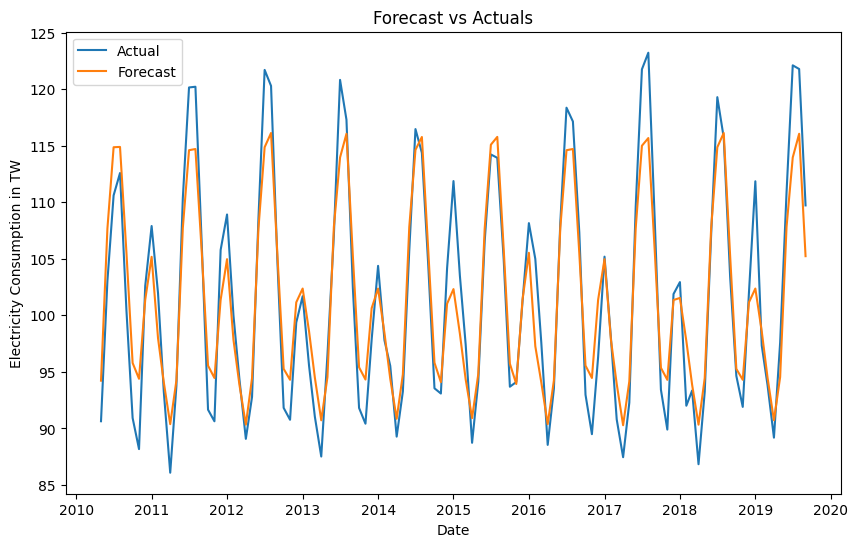

In [48]:
# Plot prediction model
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Forecast')
plt.legend(loc='upper left')
plt.title(f'Forecast vs Actuals')
plt.ylabel('Electricity Consumption in TW')
plt.xlabel('Date')
plt.show()

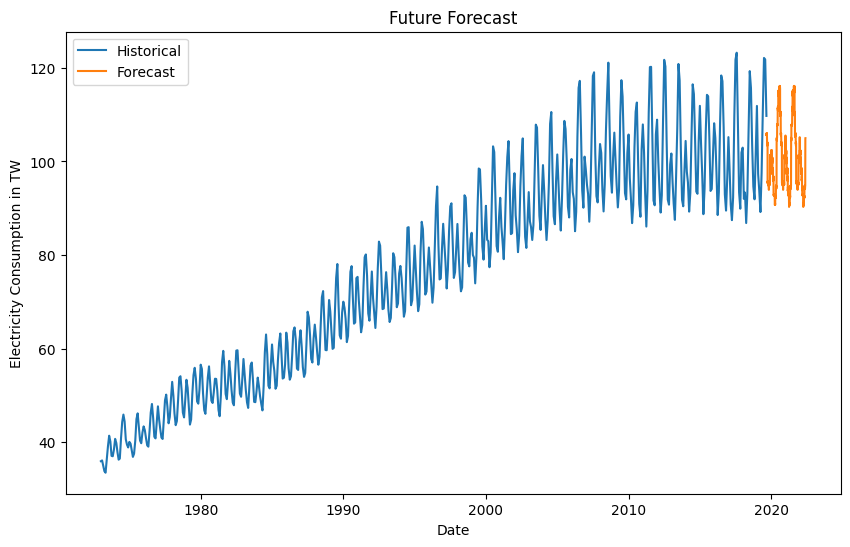

In [49]:
def create_future_dataframe(data, periods):
    last_date = data.index[-1]
    future_dates = pd.date_range(last_date, periods=periods, freq='D')[1:]
    future_df = pd.DataFrame(index=future_dates)
    future_df['year'] = future_df.index.year
    future_df['month'] = future_df.index.month
    future_df['day'] = future_df.index.day
    future_df['dayofweek'] = future_df.index.dayofweek
    future_df['weekofyear'] = future_df.index.isocalendar().week.astype(int)
    return future_df

# Create a future dataframe
future_df = create_future_dataframe(data, periods=1000)

# Use the model to predict electricity consumption in the next For example 1,000 days
future_df['Electricty_Consumption_in_TW'] = model.predict(future_df)

plt.figure(figsize=(10, 6))
plt.plot(df.index, data['Electricty_Consumption_in_TW'], label='Historical')
plt.plot(future_df.index, future_df['Electricty_Consumption_in_TW'], label='Forecast')
plt.legend(loc='upper left')
plt.title('Future Forecast')
plt.ylabel('Electricity Consumption in TW')
plt.xlabel('Date')
plt.show()

In [50]:
# Calculate RMSE, MAPE and R2
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2_LightGBM = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')
print(f'R2: {r2_LightGBM}')

RMSE: 3.478356954185911
MAPE: 2.726317445644094%
R2: 0.8818018680300729


## Model 4 - Prophet

# Prophet Model

Prophet is an open-source forecasting tool developed by Facebook, designed for automatic forecasting of time series data. It is particularly well-suited for data with strong seasonal effects and historical trends, making it useful for business forecasting, capacity planning, and anomaly detection. Here are some of the main concepts and features of Prophet:

### Key Features:

1. **Additive Model**:
   - Prophet is based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, along with holiday effects.
   - The model is expressed as:
     \[
     y(t) = g(t) + s(t) + h(t) + \epsilon_t
     \]
     where \( g(t) \) represents the trend, \( s(t) \) the seasonality, \( h(t) \) the holidays, and \( \epsilon_t \) the error term.

2. **Trend Components**:
   - **Piecewise Linear or Logistic Growth**: Prophet supports both piecewise linear and logistic growth models to capture various trend patterns.
   - **Automatic Change Point Detection**: Automatically detects points where the trend changes significantly, allowing for more accurate modeling of complex time series.

3. **Seasonality**:
   - Supports multiple seasonalities, such as yearly, weekly, and daily, which can be customized by the user.
   - Allows for flexible seasonal patterns, capturing different seasonal effects in the data.

4. **Holiday Effects**:
   - Allows inclusion of user-specified holidays and special events to improve forecasting accuracy by accounting for these effects explicitly.

5. **Handling Missing Data and Outliers**:
   - Robust to missing data and outliers, making it versatile for real-world applications where data quality might vary.

6. **Uncertainty Intervals**:
   - Provides uncertainty intervals for the forecasts, offering insights into the potential variability in the predictions.

### Common Applications:

1. **Business Forecasting**:
   - Revenue forecasting, sales prediction, and capacity planning where seasonal effects and trends play a significant role.

2. **Anomaly Detection**:
   - Detecting unusual patterns or anomalies in time series data, such as spikes or drops in demand.

3. **Capacity Planning**:
   - Planning resources based on expected future demand, useful in supply chain management and logistics.

### Advantages:

- **Ease of Use**: Designed to be easy to use, requiring minimal data preprocessing and parameter tuning.
- **Interpretable**: Provides interpretable components for trend, seasonality, and holidays, allowing for better understanding of the underlying patterns.
- **Scalable**: Can handle large datasets efficiently, making it suitable for industrial-scale applications.


In [51]:
# Database
base = pd.read_csv("/kaggle/input/electricity-demand-estimation/Electricity Consumption.csv")
base

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


In [52]:
# Transforming into datetime of the date column
base['DATE'] = pd.to_datetime(base['DATE'])

In [53]:
# Transforming date into index
base.set_index('DATE', inplace=True)

In [54]:
# Reformat the data for Prophet
# Prophet expects the data to be in a DataFrame with columns 'ds' (dates) and 'y' (values).
df_prophet = base.reset_index().rename(columns={'DATE': 'ds', 'Electricty_Consumption_in_TW': 'y'})

# Viewing dataset
df_prophet

,ds,y
0,1973-01-01,35.9728
1,1973-02-01,36.1334
2,1973-03-01,35.0625
3,1973-04-01,33.8416
4,1973-05-01,33.5107
...,...,...
556,2019-05-01,97.5860
557,2019-06-01,110.8580
558,2019-07-01,122.1014
559,2019-08-01,121.7765


In [55]:
# Training and testing division
train = df_prophet[df_prophet['ds'] < '2019-01-01']
test = df_prophet[df_prophet['ds'] >= '2019-09-01']

In [56]:
from prophet import Prophet

# Creating model
model = Prophet(changepoint_prior_scale=0.05, # Controls the flexibility of changes in trends
                seasonality_prior_scale=10.0, # Controls seasonality flexibility
                yearly_seasonality=True,
                weekly_seasonality=True,
                daily_seasonality=False)

# Model training
model.fit(train)

04:42:21 - cmdstanpy - INFO - Chain [1] start processing
04:42:21 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# Make model predictions
future = model.make_future_dataframe(periods=len(test), freq='D')
forecast = model.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1973-01-01,37.563598,37.058201,45.512310,37.563598,37.563598,3.506428,3.506428,3.506428,-0.306463,-0.306463,-0.306463,3.812891,3.812891,3.812891,0.0,0.0,0.0,41.070026
1,1973-02-01,37.711605,32.667520,41.120997,37.711605,37.711605,-0.864933,-0.864933,-0.864933,0.023423,0.023423,0.023423,-0.888357,-0.888357,-0.888357,0.0,0.0,0.0,36.846671
2,1973-03-01,37.845288,29.373777,37.625094,37.845288,37.845288,-4.330942,-4.330942,-4.330942,0.023423,0.023423,0.023423,-4.354366,-4.354366,-4.354366,0.0,0.0,0.0,33.514346
3,1973-04-01,37.993295,25.046603,33.731693,37.993295,37.993295,-8.710518,-8.710518,-8.710518,-0.148494,-0.148494,-0.148494,-8.562024,-8.562024,-8.562024,0.0,0.0,0.0,29.282777
4,1973-05-01,38.136527,27.822157,36.341744,38.136527,38.136527,-6.005053,-6.005053,-6.005053,0.072149,0.072149,0.072149,-6.077202,-6.077202,-6.077202,0.0,0.0,0.0,32.131474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,2018-09-01,101.616421,100.663284,109.054156,101.616421,101.616421,2.989974,2.989974,2.989974,0.177215,0.177215,0.177215,2.812759,2.812759,2.812759,0.0,0.0,0.0,104.606396
549,2018-10-01,101.621310,91.838381,100.289142,101.621310,101.621310,-5.444888,-5.444888,-5.444888,-0.306463,-0.306463,-0.306463,-5.138425,-5.138425,-5.138425,0.0,0.0,0.0,96.176422
550,2018-11-01,101.626362,90.691804,99.804097,101.626362,101.626362,-6.279482,-6.279482,-6.279482,0.023423,0.023423,0.023423,-6.302906,-6.302906,-6.302906,0.0,0.0,0.0,95.346880
551,2018-12-01,101.631250,97.161608,105.820741,101.631250,101.631250,0.190816,0.190816,0.190816,0.177215,0.177215,0.177215,0.013600,0.013600,0.013600,0.0,0.0,0.0,101.822066


In [58]:
# Evaluate predictions:
# Extract predictions for the test set and calculate metrics RMSE, MAPE, r2

forecast_test = forecast[forecast['ds'] >= '2020-09-01']
y_test = test['y'].values
y_pred = forecast_test['yhat'].values

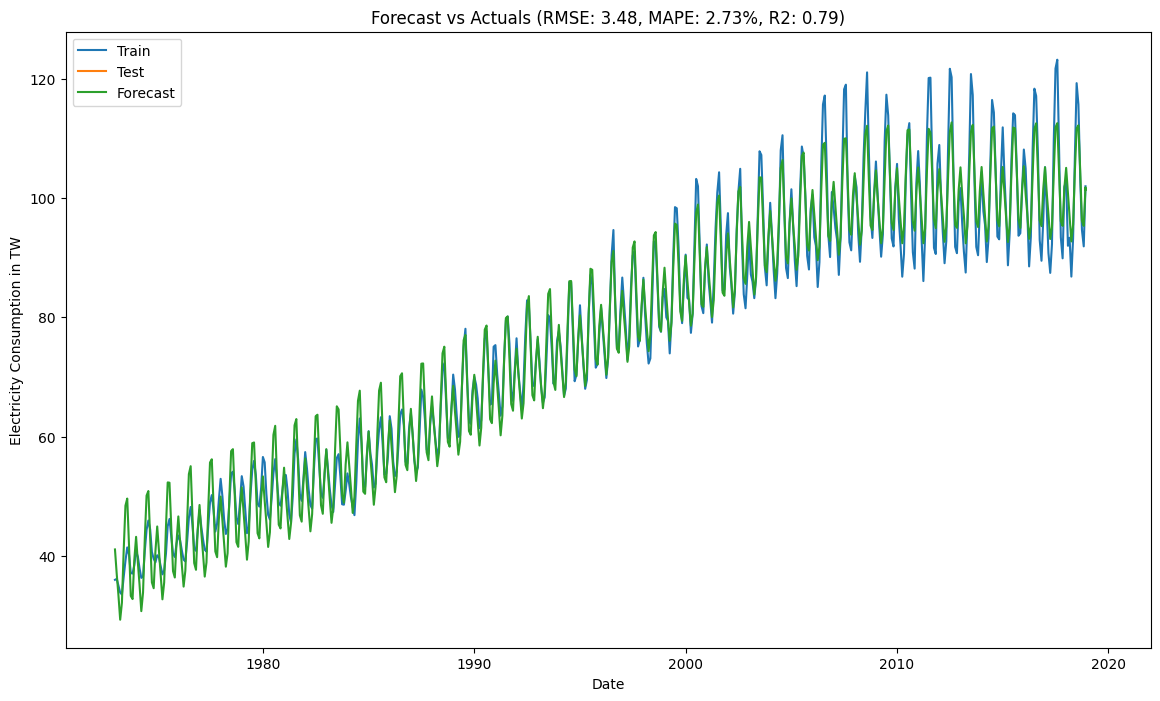

In [59]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot history and forecasts
ax.plot(train['ds'], train['y'], label='Train')
ax.plot(test['ds'], test['y'], label='Test')
ax.plot(forecast['ds'], forecast['yhat'], label='Forecast')

ax.set_title(f'Forecast vs Actuals (RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.2f})')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Consumption in TW')
ax.legend()

plt.show()

In [60]:
# Predicting the future
future_forecast = model.make_future_dataframe(periods=650)
future_forecast = model.predict(future_forecast)
future_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1973-01-01,37.563598,36.875510,45.373984,37.563598,37.563598,3.506428,3.506428,3.506428,-0.306463,-0.306463,-0.306463,3.812891,3.812891,3.812891,0.0,0.0,0.0,41.070026
1,1973-02-01,37.711605,32.621577,40.937011,37.711605,37.711605,-0.864933,-0.864933,-0.864933,0.023423,0.023423,0.023423,-0.888357,-0.888357,-0.888357,0.0,0.0,0.0,36.846671
2,1973-03-01,37.845288,29.436304,37.863548,37.845288,37.845288,-4.330942,-4.330942,-4.330942,0.023423,0.023423,0.023423,-4.354366,-4.354366,-4.354366,0.0,0.0,0.0,33.514346
3,1973-04-01,37.993295,24.937569,33.612943,37.993295,37.993295,-8.710518,-8.710518,-8.710518,-0.148494,-0.148494,-0.148494,-8.562024,-8.562024,-8.562024,0.0,0.0,0.0,29.282777
4,1973-05-01,38.136527,28.194758,36.462763,38.136527,38.136527,-6.005053,-6.005053,-6.005053,0.072149,0.072149,0.072149,-6.077202,-6.077202,-6.077202,0.0,0.0,0.0,32.131474


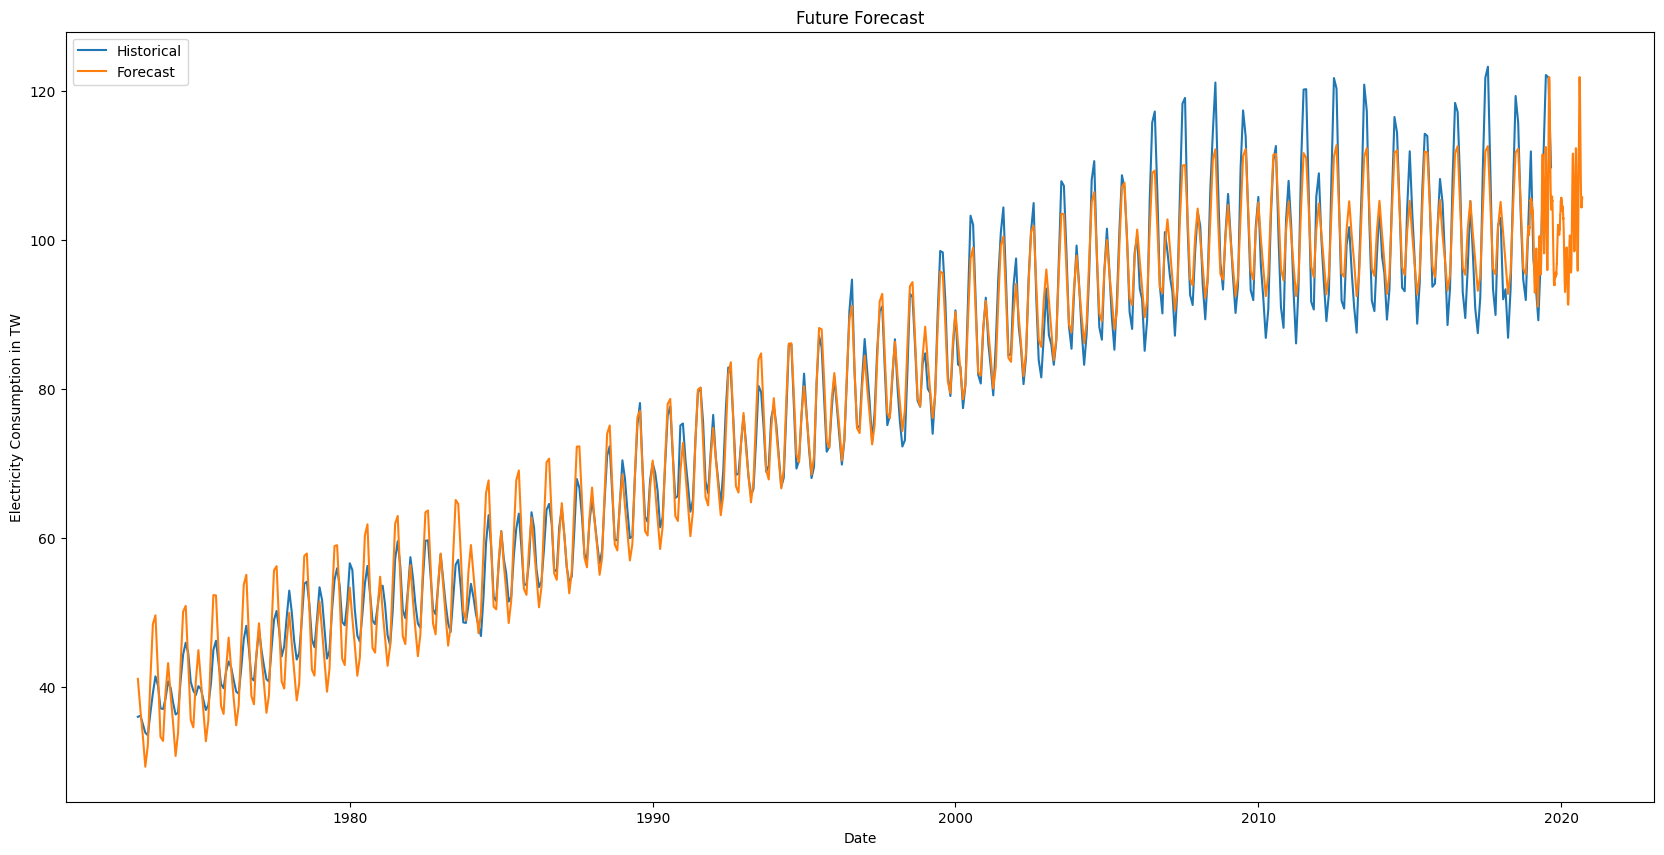

In [61]:
# Plot the results with the legend
fig, ax = plt.subplots(figsize=(20.5, 10))

# Plot history and future predictions
ax.plot(df_prophet['ds'], df_prophet['y'], label='Historical')
ax.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast')

ax.set_title('Future Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity Consumption in TW')
ax.legend()

plt.show()